<a href="https://colab.research.google.com/github/Navaneeth1235/AI-Image-Recognition-Chatbot/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [2]:
# Load the dataset
df = pd.read_csv('Fraud.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check class distribution (fraud vs non-fraud)
print("\nClass distribution:")
print(df['isFraud'].value_counts(normalize=True))

Dataset shape: (42271, 11)

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  

Missing values per column:
step              0
type           

In [3]:
# Handle missing values for merchant transactions (nameDest starting with 'M')
df.loc[df['nameDest'].str.startswith('M'), ['oldbalanceDest', 'newbalanceDest']] = 0

# Convert 'type' to categorical and one-hot encode
df['type'] = df['type'].astype('category')
df = pd.get_dummies(df, columns=['type'], prefix='type')

# Drop columns that won't be used in modeling (like IDs)
# Note: We might extract patterns from these later
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# Create new features
df['origBalanceChange'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['destBalanceChange'] = df['newbalanceDest'] - df['oldbalanceDest']
df['absAmountBalanceDiff'] = abs(df['amount'] - df['origBalanceChange'])

In [6]:
# Check for NaN in target variable
print("Number of NaN in isFraud:", df['isFraud'].isna().sum())

# Option 1: Drop rows with NaN in target (if few)
df = df.dropna(subset=['isFraud'])

# Option 2: Fill NaN with a specific value (e.g., 0 for non-fraud)
# df['isFraud'] = df['isFraud'].fillna(0)

# Verify no more NaN
print("NaN after cleaning:", df['isFraud'].isna().sum())

Number of NaN in isFraud: 1
NaN after cleaning: 0


In [7]:
# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print("Resampled class distribution:")
print(pd.Series(y_train_res).value_counts())

Resampled class distribution:
isFraud
0.0    33741
1.0    33741
Name: count, dtype: int64


In [10]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay

# Initialize models
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'  # Optimize for precision-recall
)

rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# Train models
print("Training XGBoost...")
xgb_model.fit(X_train_res, y_train_res)

print("\nTraining Random Forest...")
rf_model.fit(X_train_res, y_train_res)

Training XGBoost...

Training Random Forest...


RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42)

XGBoost Evaluation:

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8435
         1.0       0.52      0.89      0.65        19

    accuracy                           1.00      8454
   macro avg       0.76      0.95      0.83      8454
weighted avg       1.00      1.00      1.00      8454

ROC AUC: 0.9986


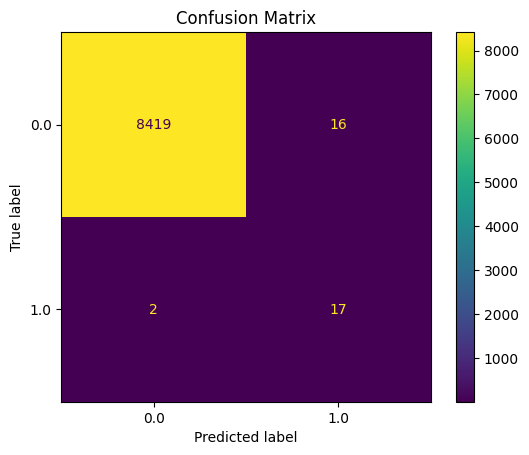

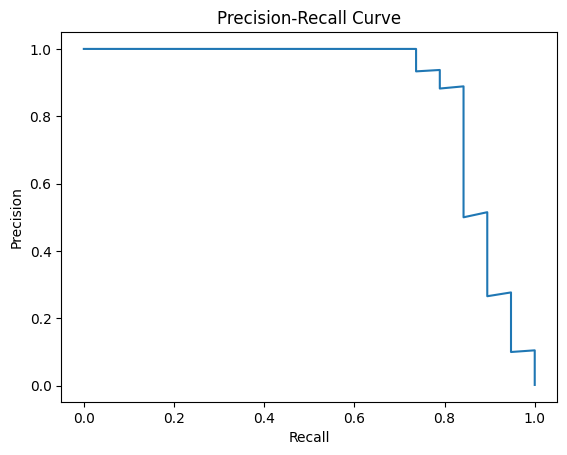


Random Forest Evaluation:

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8435
         1.0       0.76      0.84      0.80        19

    accuracy                           1.00      8454
   macro avg       0.88      0.92      0.90      8454
weighted avg       1.00      1.00      1.00      8454

ROC AUC: 0.9989


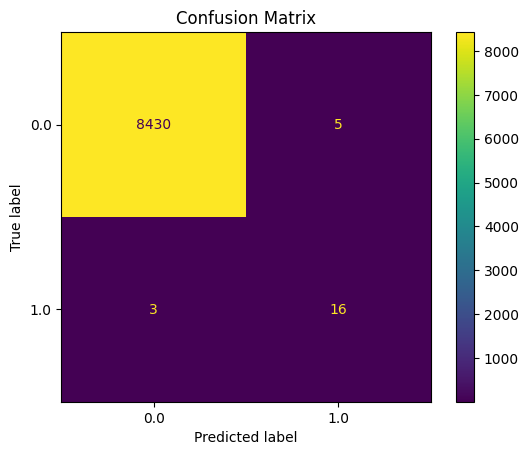

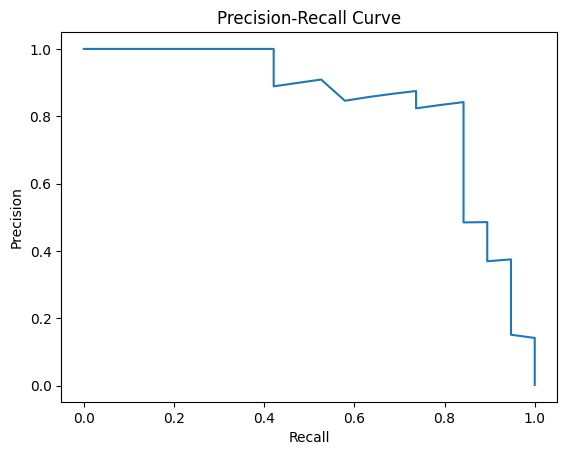

In [11]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title('Confusion Matrix')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

print("XGBoost Evaluation:")
evaluate_model(xgb_model, X_test, y_test)

print("\nRandom Forest Evaluation:")
evaluate_model(rf_model, X_test, y_test)

<Figure size 1200x800 with 0 Axes>

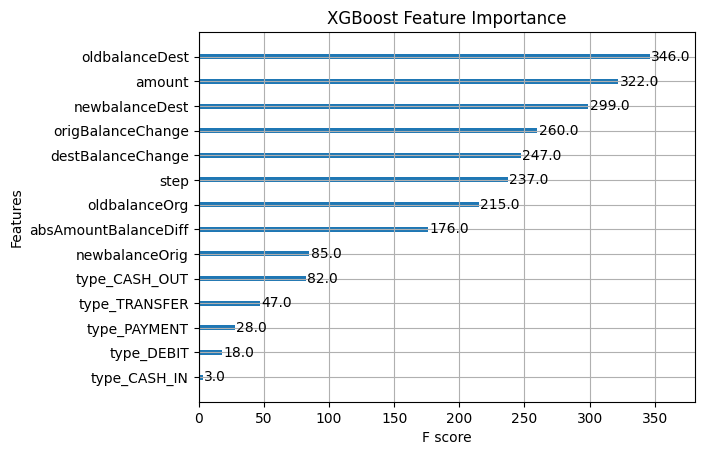

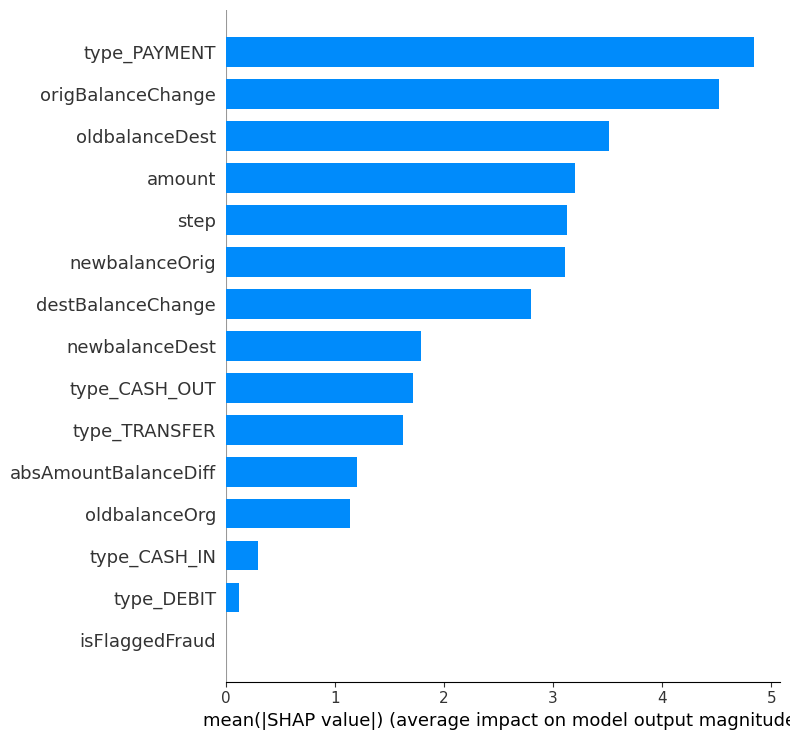

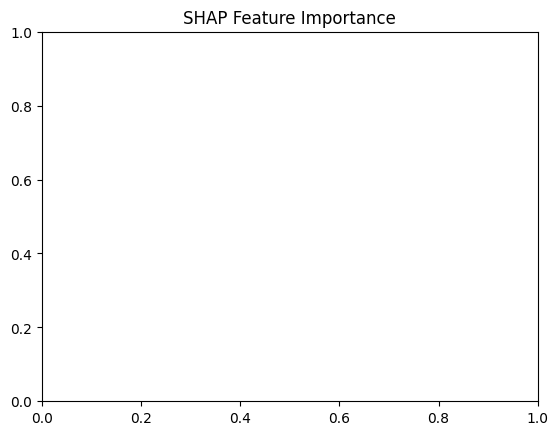

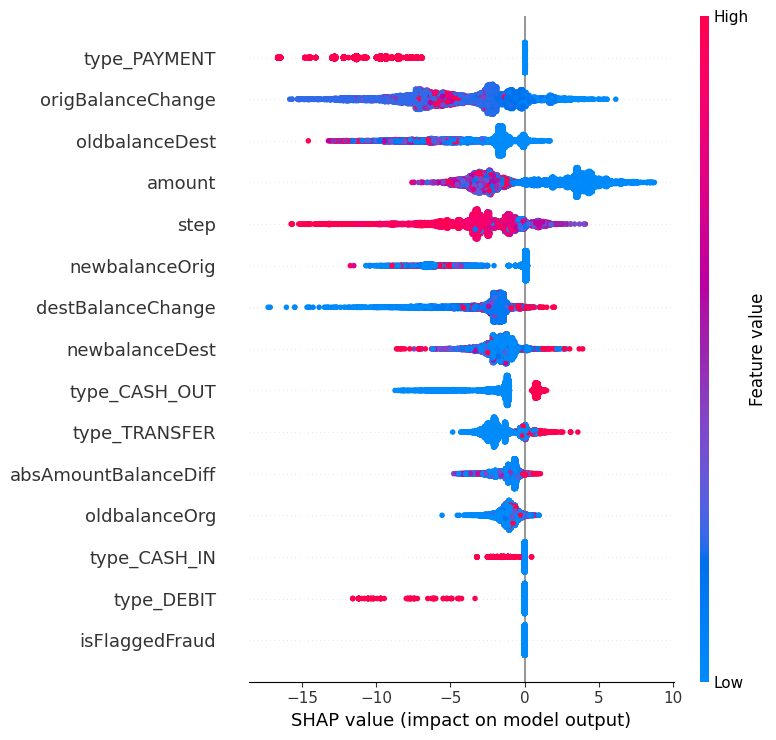

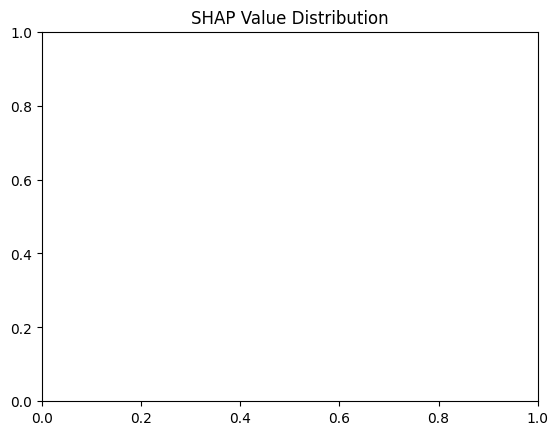

In [14]:
# XGBoost Feature Importance
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

# SHAP Values for interpretability (sample 1000 instances for speed)
import shap
shap_sample = X_test.sample(7000, random_state=42)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(shap_sample)

shap.summary_plot(shap_values, shap_sample, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.show()

shap.summary_plot(shap_values, shap_sample)
plt.title('SHAP Value Distribution')
plt.show()

In [15]:
# Examine high-risk transactions
X_test['fraud_prob'] = xgb_model.predict_proba(X_test)[:,1]
high_risk = X_test.sort_values('fraud_prob', ascending=False).head(10)
pd.concat([high_risk, y_test[y_test.index.isin(high_risk.index)]], axis=1)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,origBalanceChange,destBalanceChange,absAmountBalanceDiff,fraud_prob,isFraud
5558,6,33332.86,33332.86,0.0,0.0,0.00,0.0,False,False,False,False,True,-33332.86,0.00,66665.72,1.0,1.0
10218,7,21729.00,21729.00,0.0,0.0,0.00,0.0,False,False,False,False,True,-21729.00,0.00,43458.00,1.0,1.0
4260,3,22877.00,22877.00,0.0,0.0,0.00,0.0,False,False,False,False,True,-22877.00,0.00,45754.00,1.0,1.0
4775,4,86070.17,86070.17,0.0,0.0,0.00,0.0,False,False,False,False,True,-86070.17,0.00,172140.34,1.0,1.0
4441,4,10000000.00,10000000.00,0.0,0.0,9941904.21,0.0,False,True,False,False,False,-10000000.00,9941904.21,20000000.00,1.0,1.0
5852,6,26768.50,26768.50,0.0,0.0,0.00,0.0,False,False,False,False,True,-26768.50,0.00,53537.00,1.0,1.0
6707,6,17246.00,17246.00,0.0,0.0,17246.00,0.0,False,True,False,False,False,-17246.00,17246.00,34492.00,1.0,1.0
4693,4,13707.11,13707.11,0.0,0.0,0.00,0.0,False,False,False,False,True,-13707.11,0.00,27414.22,1.0,1.0
6702,6,17320.91,17320.91,0.0,0.0,0.00,0.0,False,False,False,False,True,-17320.91,0.00,34641.82,1.0,1.0
3059,2,1096187.24,1096187.24,0.0,0.0,0.00,0.0,False,False,False,False,True,-1096187.24,0.00,2192374.48,1.0,1.0


Optimal Threshold: 0.9994


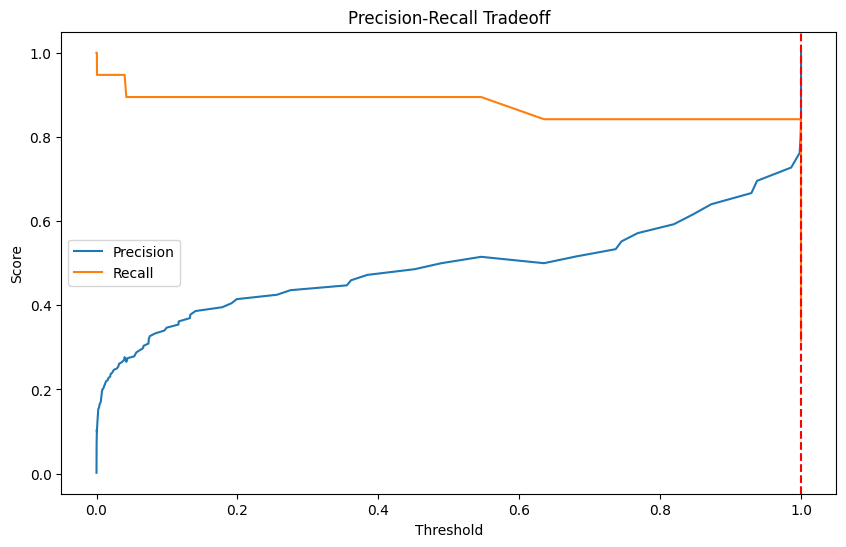

In [18]:
# First, make sure we're working with clean test features
X_test_for_model = X_test.drop(columns=['fraud_prob'], errors='ignore')  # Remove if exists

# Get predicted probabilities
y_proba = xgb_model.predict_proba(X_test_for_model)[:,1]

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find optimal threshold (where precision >= 80%)
optimal_idx = np.where(precision >= 0.8)[0][0]
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Visualize precision-recall vs threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [19]:
# Before any predictions, ensure X_test matches training format
X_test = X_test[X_train_res.columns]

In [21]:
def safe_evaluate_model(model, X_test, y_test):
    # Ensure feature alignment
    X_test = X_test[X_train_res.columns]

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

In [24]:
# Get feature importance
feature_imp = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 5 fraud indicators
print("Top 5 Fraud Indicators:")
print(feature_imp.head(20))

# Create rules based on top features
top_features = feature_imp['feature'].head(3).tolist()
print("\nSuggested Business Rules:")
print(f"1. Flag transactions with high {top_features[0]}")
print(f"2. Review when {top_features[1]} exceeds normal range")
print(f"3. Verify unusual patterns in {top_features[2]}")

Top 5 Fraud Indicators:
                 feature  importance
7           type_CASH_IN    0.695385
10          type_PAYMENT    0.259812
9             type_DEBIT    0.009785
4         oldbalanceDest    0.006527
0                   step    0.004438
12     origBalanceChange    0.004411
13     destBalanceChange    0.003083
5         newbalanceDest    0.003027
8          type_CASH_OUT    0.002925
3         newbalanceOrig    0.002833
11         type_TRANSFER    0.002570
2          oldbalanceOrg    0.002140
14  absAmountBalanceDiff    0.001673
1                 amount    0.001391
6         isFlaggedFraud    0.000000

Suggested Business Rules:
1. Flag transactions with high type_CASH_IN
2. Review when type_PAYMENT exceeds normal range
3. Verify unusual patterns in type_DEBIT


In [25]:
# Ensure test set matches training features exactly
X_test = X_test[X_train_res.columns]
assert list(X_train_res.columns) == list(X_test.columns), "Feature mismatch!"

In [26]:
#Comprehensive evalution metrics
from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Key Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                           display_labels=['Legit', 'Fraud'],
                                           cmap='Blues')
    plt.title('Confusion Matrix (Counts)')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall (Fraud Detection Rate)')
    plt.ylabel('Precision (Accuracy When Flagged)')
    plt.title(f'Precision-Recall Curve (AP={average_precision_score(y_test, y_proba):.2f})')
    plt.show()

In [27]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(xgb_model, X_train_res, y_train_res,
                           cv=3, scoring='average_precision')
print(f"Cross-Validated AP: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validated AP: 1.00 ± 0.00


In [29]:
#Rule Generation
# Top 3 actionable rules
top_rules = {
    "Large TRANSFER+CASH_OUT":
        "(df['type_TRANSFER'] == 1) | (df['type_CASH_OUT'] == 1)& (df['amount'] > 100000)",
    "Balance Mismatch":
        "abs(df['amount'] - df['origBalanceChange']) > df['amount'] * 0.5",
    "Emptying Account":
        "(df['newbalanceOrig'] < 100) & (df['amount'] > 50000)"
}

for name, rule in top_rules.items():
    fraud_rate = df[eval(rule)]['isFraud'].mean()
    print(f"Rule: {name} \n-> Fraud Rate: {fraud_rate:.1%} \n-> Condition: {rule}\n")

Rule: Large TRANSFER+CASH_OUT 
-> Fraud Rate: 0.6% 
-> Condition: (df['type_TRANSFER'] == 1) | (df['type_CASH_OUT'] == 1)& (df['amount'] > 100000)

Rule: Balance Mismatch 
-> Fraud Rate: 0.3% 
-> Condition: abs(df['amount'] - df['origBalanceChange']) > df['amount'] * 0.5

Rule: Emptying Account 
-> Fraud Rate: 0.3% 
-> Condition: (df['newbalanceOrig'] < 100) & (df['amount'] > 50000)



Cost-Optimal Threshold: 0.020


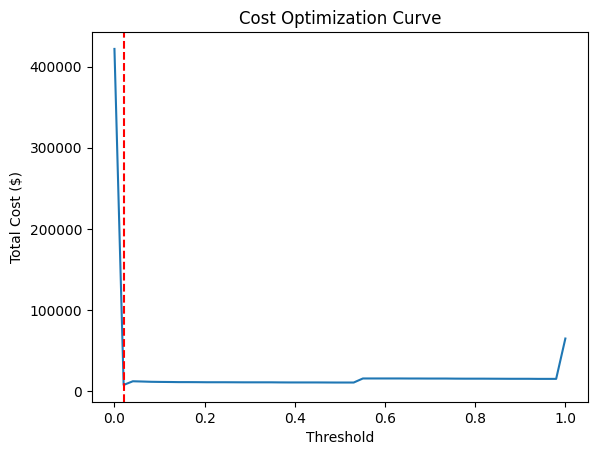

In [30]:
# Calculate costs at different thresholds
thresholds = np.linspace(0, 1, 50)
costs = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    fn_cost = sum((y_pred == 0) & (y_test == 1)) * 5000
    fp_cost = sum((y_pred == 1) & (y_test == 0)) * 50
    costs.append(fn_cost + fp_cost)

# Optimal threshold
optimal_threshold = thresholds[np.argmin(costs)]
print(f"Cost-Optimal Threshold: {optimal_threshold:.3f}")

# Plot
plt.plot(thresholds, costs)
plt.axvline(optimal_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost Optimization Curve')
plt.show()

In [31]:
# Final predictions with optimized threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print("\nOptimized Performance:")
print(classification_report(y_test, y_pred_optimal))


Optimized Performance:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      8435
         1.0       0.24      0.95      0.38        19

    accuracy                           0.99      8454
   macro avg       0.62      0.97      0.69      8454
weighted avg       1.00      0.99      1.00      8454



In [33]:
import pickle

# Save model
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)  # Replace xgb_model with your model variable

In [34]:
xgb_model.save_model('fraud_model.json')  # JSON format
# or
xgb_model.save_model('fraud_model.ubj')  # Binary format

In [36]:
from sklearn.pipeline import Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('model', xgb_model)
])

# Save entire pipeline
with open('full_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)